In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

# Gridding and diagnostic images

This tutorial covers how to read visibility data, average it to a "grid", and make diagnostic images.

## Importing data

We'll use a mock CASA measurement set that we produced as part of the [mpoldatasets](https://github.com/MPoL-dev/mpoldatasets) package. One of the tricky things about working with CASA measurement sets is that you need to use CASA to read the visibilities themselves. CASA has historically been packaged as a "monolithic" distribution with its own Python interpreter (which is difficult to install new packages into). Recently, ["modular" CASA](https://casa.nrao.edu/casadocs-devel/stable/usingcasa/obtaining-and-installing) has made it possible to install the CASA routines into your own Python environment---however the package is only supported on Python 3.6 and RHEL 7 linux. To avoid propagating these restrictive installation requirements to MPoL, we assume that the user provides the arrays of complex visibilities directly. The data requirements of RML imaging are really that simple.

In our opinion, the most straightforward way of obtaining the visibilities from a measurement set is to use the CASA ``table`` and ``ms`` tools as described [here](https://mpol-dev.github.io/visread/). The user can use either "monolithic" or "modular" CASA to read the visibilities and save them to a ``.npy`` array on disk. Then, in your normal (less restrictive) Python environment (e.g., Python 3.9, MacOS) you can read these visibilities and pass them to the MPoL routines.

It's important to remember that MPoL follows the standard baseline convention as laid out in [Thompson, Moran, and Swenson](https://ui.adsabs.harvard.edu/abs/2017isra.book.....T/abstract) and other radio interferometry textbooks, while CASA follows a [historically complicated convention](https://casa.nrao.edu/casadocs/casa-5.5.0/knowledgebase-and-memos/casa-memos/casa_memo2_coordconvention_rau.pdf/view) derived from AIPS. The difference between the two can be expressed as the complex conjugate of the visibilities. So, if you find that your image appears upside down and mirrored, you'll want to take ``np.conj`` of your visibilities.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.utils.data import download_file

In [4]:
# load the mock dataset of the ALMA logo
fname = download_file(
    "https://zenodo.org/record/4930016/files/logo_cube.noise.npz",
    cache=True,
    show_progress=True,
    pkgname="mpol",
)

In [5]:
d = np.load(fname)
uu = d["uu"]
vv = d["vv"]
weight = d["weight"]
data = d["data"]
data_re = np.real(data)
data_im = np.imag(data)

## The GridCoords object

In [6]:
from mpol import coordinates, gridding

 The first MPoL object we'll familiarize ourselves with is GridCoords. Two numbers, `cell_size` and `npix`, uniquely define a grid in image space and Fourier space.

In [7]:
coords = coordinates.GridCoords(cell_size=0.005, npix=800)

The GridCoords object is mainly a container for all of the information about this grid. You can see all of the properties accessible in the [GridCoords](../api.rst#mpol.coordinates.GridCoords) API documentation. The information you'll most likely want to access are the image dimensions

In [8]:
coords.img_ext  # [arcsec]

[1.9975, -2.0025, -2.0025, 1.9975]

which are meant to feed into the `extent` parameter of `matplotlib.pyplot.imshow`.

## The Gridder object

The purpose of the gridder is to take in loose visibility data (as from an ALMA observation) and average it to cells defined by the GridCoords. We can instantiate a Gridder object by

In [9]:
gridder = gridding.Gridder(
    coords=coords,
    uu=uu,
    vv=vv,
    weight=weight,
    data_re=data_re,
    data_im=data_im,
)

Note that the `uu`, `vv`, `weight`, `data_re`, and `data_im` arrays are all two-dimensional numpy arrays of shape `(nchan, nvis)`. This is because MPoL has the capacity to image spectral line observations. MPoL will absolutely still work with single-channel continuum data, you will just need to work with 2D arrays of shape `(1, nvis)`.
Instantiating the `Gridder` object attaches the GridCoords object and the loose visibilities. There is also a convenience method to create the GridCoords and Gridder object in one shot by

In [10]:
gridder = gridding.Gridder(
    cell_size=0.005,  # [arcsec]
    npix=800,
    uu=uu,
    vv=vv,
    weight=weight,
    data_re=data_re,
    data_im=data_im,
)

if you don't want to specify your GridCoords object separately.

## Visualizing the images
To visualize the images, you can call [Gridder.get_dirty_image](../api.rst#mpol.gridding.Gridder.get_dirty_image). This routine will average, or 'grid', the loose visibilities to the Fourier grid defined by GridCoords and then calculate the diagnostic dirty image and dirty beam cubes that correspond to the Fourier transform of the gridded visibilities.
There are several different schemes by which to do the averaging, each of which will deliver different image plane resolutions (defined by the size of the PSF or dirty beam) and thermal noise properties. MPoL implements 'uniform', 'natural', and 'briggs' robust weighting. For more information on the difference between these schemes, see the [CASA documentation](https://casa.nrao.edu/casadocs-devel/stable/imaging/synthesis-imaging/data-weighting) or Chapter 3 of Daniel Briggs' [Ph.D. thesis.](http://www.aoc.nrao.edu/dissertations/dbriggs/).
We are usually interested in the diagnostic beam and image cubes that correspond to these gridded visibilities, frequently called the "dirty beam" and "dirty image" by radio astronomers. Those are accessible via the following routine

In [11]:
img, beam = gridder.get_dirty_image(weighting="briggs", robust=0.0)

Note that these are three dimensional image cubes with the same `nchan` as the input visibility data.

In [12]:
print(beam.shape)
print(img.shape)

(9, 800, 800)
(9, 800, 800)


And the image has units of "Jy/beam".

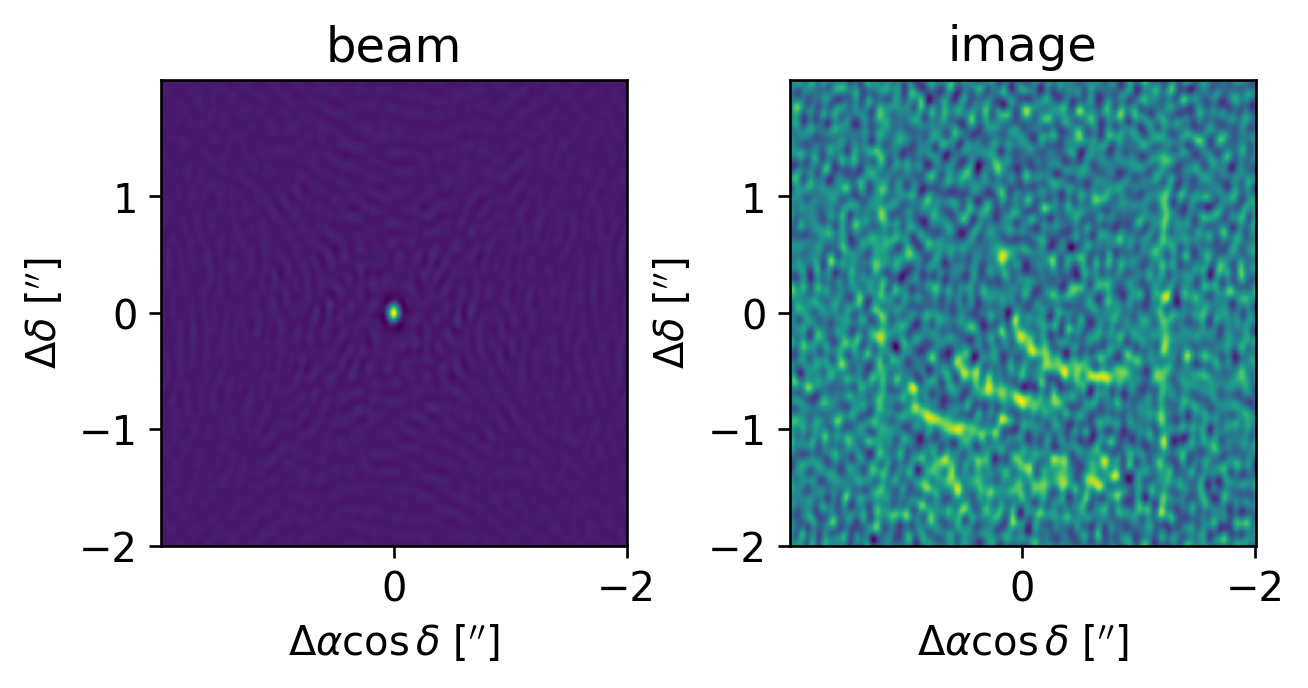

In [13]:
chan = 4
kw = {"origin": "lower", "interpolation": "none", "extent": gridder.coords.img_ext}
fig, ax = plt.subplots(ncols=2, figsize=(6.0, 4))
ax[0].imshow(beam[chan], **kw)
ax[0].set_title("beam")
ax[1].imshow(img[chan], **kw)
ax[1].set_title("image")
for a in ax:
    a.set_xlabel(r"$\Delta \alpha \cos \delta$ [${}^{\prime\prime}$]")
    a.set_ylabel(r"$\Delta \delta$ [${}^{\prime\prime}$]")
fig.subplots_adjust(left=0.14, right=0.90, wspace=0.35, bottom=0.15, top=0.9)

If you were working with this measurement set in CASA, it's a good idea to compare the dirty image produced here to the dirty image from CASA (i.e., produced by `tclean` with zero CLEAN iterations). You should confirm that these two dirty images look very similar (i.e., nearly but most likely not quite to numerical precision) before moving on to regularized maximum imaging. If your image appears upside down or mirrored, check whether you converted your visibility data from the CASA baseline convention to the regular TMS baseline convention by conjugating your visibilities.

## Checking data weights
When working with real data, it is possible that the statistical uncertainties---conveyed by the weights---were [not correctly calibrated by certain CASA versions](https://mpol-dev.github.io/visread/tutorials/rescale_AS209_weights.html). For dirty and CLEAN imaging purposes, it's OK if the weights are not correctly scaled so long as their *relative* scalings are correct (to each other). For forward-modeling and RML imaging, it's important that the weights are correctly scaled in an absolute sense. To alert the user to the possibility that their weights may be incorrectly calibrated, the dirty imaging routines will raise a ``RuntimeWarning`` if the weights are incorrectly scaled. Even though the weights are incorrect, the dirty image may still be valid---hence why these routines issue a warning.

```
  img, beam = gridder.get_dirty_image(
        weighting="uniform", check_visibility_scatter=True, max_scatter=1.2
  )
```

However, if the user goes to export the gridded visibilities as a PyTorch dataset for RML imaging, incorrectly scaled weights will raise a RuntimeError. RML images and forward modeling inferences will be compromised if the weights are not statistically valid.

The sensitivity of the export routines can be adjusted by changing the ``max_scatter`` keyword. Scatter checking can be disabled by setting ``check_visibility_scatter=False``, but is not recommended unless you are trying to debug things.

```
  dset = gridder.to_pytorch_dataset(check_visibility_scatter=True, max_scatter=1.2)
```